# Gaussian Splatting

Gaussian Splatting is a differentiable rasterization technique. It enables an ML-friendly representation of 3D.

Let's put it into practice with [LGM](https://huggingface.co/ashawkey/LGM).

## Setup

Install the required libraries.

In [1]:
!pip install -r https://huggingface.co/spaces/dylanebert/LGM-mini/raw/main/requirements.txt
!pip install https://huggingface.co/spaces/dylanebert/LGM-mini/resolve/main/wheel/diff_gaussian_rasterization-0.0.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of rembg[cli,gpu] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 92.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.4/755.4 MB 2.1 MB/s et

In [3]:

# 또는 단순히
!pip install -U xformers

  Using cached xformers-0.0.35-py39-none-manylinux_2_28_x86_64.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.2 MB/s eta 0:00:00


In [6]:
# 관련 라이브러리 직접 설치
!git clone --recursive https://github.com/graphdeco-inria/diff-gaussian-rasterization
!pip install ./diff-gaussian-rasterization


Cloning into 'diff-gaussian-rasterization'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 329 (delta 183), reused 177 (delta 177), pack-reused 124 (from 1)
Receiving objects: 100% (329/329), 112.49 KiB | 7.03 MiB/s, done.
Resolving deltas: 100% (219/219), done.
Submodule 'third_party/glm' (https://github.com/g-truc/glm.git) registered for path 'third_party/glm'
Cloning into '/content/diff-gaussian-rasterization/third_party/glm'...
remote: Enumerating objects: 60961, done.        
remote: Counting objects: 100% (589/589), done.        
remote: Compressing objects: 100% (259/259), done.        
remote: Total 60961 (delta 457), reused 330 (delta 330), pack-reused 60372 (from 4)        
Receiving objects: 100% (60961/60961), 72.99 MiB | 29.43 MiB/s, done.
Resolving deltas: 100% (46300/46300), done.
Submodule path 'third_party/glm': checked out '5c46b9c07008ae65cb81ab79cd677ecc1934b903

# Pipeline

Create a multi-view diffusion pipeline, as in the previous notebook. This is the first step in LGM.

In [8]:
!pip install kiui einops transformers accelerate diffusers

  Using cached kiui-0.3.3-py3-none-any.whl.metadata (16 kB)
  Using cached varname-0.15.1-py3-none-any.whl.metadata (13 kB)
  Using cached objprint-0.3.0-py3-none-any.whl.metadata (25 kB)
  Using cached questionary-2.1.1-py3-none-any.whl.metadata (5.4 kB)
  Using cached executing-2.2.1-py2.py3-none-any.whl.metadata (8.9 kB)
Using cached kiui-0.3.3-py3-none-any.whl (3.2 MB)
Using cached objprint-0.3.0-py3-none-any.whl (41 kB)
Using cached questionary-2.1.1-py3-none-any.whl (36 kB)
Using cached varname-0.15.1-py3-none-any.whl (25 kB)
Using cached executing-2.2.1-py2.py3-none-any.whl (28 kB)


In [9]:
import torch
from diffusers import DiffusionPipeline

image_pipeline = DiffusionPipeline.from_pretrained(
    "dylanebert/multi-view-diffusion",
    custom_pipeline="dylanebert/multi-view-diffusion",
    torch_dtype=torch.float16,
    trust_remote_code=True,
).to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Keyword arguments {'trust_remote_code': True} are not expected by MVDreamPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/519 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers_modules.local.dylanebert--multi-view-diffusion.3916e5568b2ee54ea8a81ce4961609158b2c464d.pipeline.MultiViewUNetModel'>,), got <class 'diffusers_modules.local.mv_unet.MultiViewUNetModel'>.


Then, create an LGM pipeline. This model generates a splat given multi-view images, and is the main contribution of the [LGM](https://huggingface.co/ashawkey/LGM) research project.

In [10]:
splat_pipeline = DiffusionPipeline.from_pretrained(
    "dylanebert/LGM",
    custom_pipeline="dylanebert/LGM",
    torch_dtype=torch.float16,
    trust_remote_code=True,
).to("cuda")

model_index.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

pipeline.py: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Keyword arguments {'trust_remote_code': True} are not expected by LGMPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/1 [00:00<?, ?it/s]

This modeling file might require the following packages that were not found in your environment: plyfile. Run `pip install plyfile`
/root/.cache/huggingface/modules/diffusers_modules/local/lgm.py:334: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")


Load the input image.

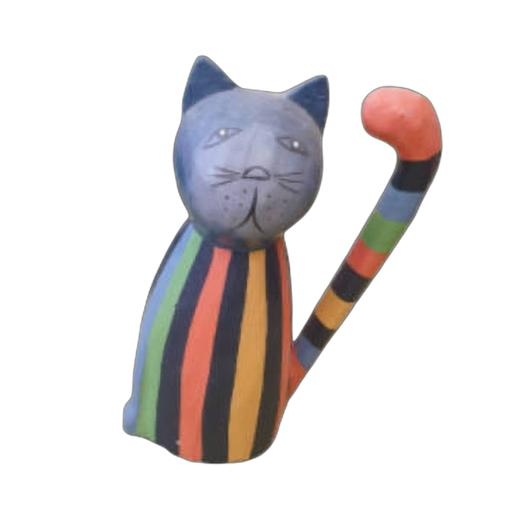

In [11]:
import requests
from PIL import Image
from io import BytesIO


image_url = "https://huggingface.co/datasets/dylanebert/3d-arena/resolve/main/inputs/images/a_cat_statue.jpg"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
image

Finally, pass the image through both pipelines. The result with be a matrix of splat data, which can be saved with `splat_pipeline.save_ply`.

The output will be saved to `/tmp/output.ply`, then downloaded using colab utilities.

In [13]:
!pip install plyfile

  Using cached plyfile-1.1.3-py3-none-any.whl.metadata (43 kB)
Using cached plyfile-1.1.3-py3-none-any.whl (36 kB)


In [14]:
import numpy as np
from google.colab import files

input_image = np.array(image, dtype=np.float32) / 255.
multi_view_images = image_pipeline("", input_image, guidance_scale=5, num_inference_steps=30, elevation=0)
splat = splat_pipeline(multi_view_images)

output_path = "/tmp/output.ply"
splat_pipeline.save_ply(splat, output_path)
files.download(output_path)

  0%|          | 0/30 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Congratulations!

To view the `output.ply` splat file, upload it in a viewer like [gradio/model3D](https://huggingface.co/spaces/gradio/model3D).

Alternatively, for more advanced functionality (e.g. coordinate system correction, converting to `.splat`), upload it to an editor like [gsplat editor](https://huggingface.co/spaces/dylanebert/gsplat-editor) or [SuperSplat](https://playcanvas.com/supersplat/editor).

## Gradio Demo

In [15]:
import gradio as gr

def run(image):
    input_image = image.astype("float32") / 255.0
    images = image_pipeline("", input_image, guidance_scale=5, num_inference_steps=30, elevation=0)
    splat = splat_pipeline(images)
    output_path = "/tmp/output.ply"
    splat_pipeline.save_ply(splat, output_path)
    return output_path

demo = gr.Interface(fn=run, inputs="image", outputs=gr.Model3D())
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c8b4c1ba5350208a7e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
